In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.interpolate import interp1d
from numpy import savetxt
import os
import sys
from pathlib import Path


In [2]:
drive.mount('/content/drive')
dir_name ='/content/drive/My Drive/new_kimore/EX2/'
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
def segmentation(pid,activity):
  if(pid=='P22' or pid=='P56' or pid=='P41' or pid=='P36'):
    num_segments = 6
  elif(pid=='P32'):
    num_segments = 8
  elif(pid=='P18' or pid=='P9' or pid=='P29'or pid=='P74' or pid=='P19'or pid=='P67' or pid=='P13'or pid=='P76' or pid=='P69'or pid=='P51' or pid=='P3'or pid=='P75' or pid=='P63'):
    num_segments = 4
  else:
    num_segments = 5
  n_rows_to_delete = 15
  # Delete the first and last n_rows_to_delete rows
  activity = activity.iloc[n_rows_to_delete:-n_rows_to_delete]

  # Reset the index if needed
  activity = activity.reset_index(drop=True)

  one_channel_data = activity.iloc[:, 48]#LEFT LEG HIP
  # Calculate the number of rows per segment
  num_rows = len(activity)
  rows_per_segment = num_rows // num_segments
  # Segment the DataFrame into 6 pieces
  segments = []
  for i in range(num_segments):
      start_idx = i * rows_per_segment
      end_idx = (i + 1) * rows_per_segment if i < num_segments - 1 else num_rows
      segment = activity.iloc[start_idx:end_idx]
      segments.append(segment)
  if(pid=='P11'):
    one_sample = segments[0].iloc[:, 48]
    # Create a time axis (assuming samples are taken at regular intervals)
    time_axis = range(len(one_sample))

    # Plot the one channel's signal
    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
    plt.plot(time_axis, one_sample, label='left hip joint', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Signal for left hip joint')
    plt.legend()
    plt.grid(True)
    plt.show()

    time_axis = range(len(one_channel_data))

    # Plot the one channel's signal
    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
    plt.plot(time_axis, one_channel_data, label='left hip joint', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Signal for left hip joint')
    plt.legend()
    plt.grid(True)
    plt.show()
  first_three_segments=segments[:3]
  return first_three_segments

In [4]:
def inter_dec(data_original_list):
  # Define the desired length for interpolation
  desired_length = 100
  interpolated_list=[]
  column_names = ["col" + str(i) for i in range(1, 81)]
  #decide if it is decimation or interpolation
  for i in range(len(data_original_list)):
    original_df=data_original_list[i]
    num_rows = original_df.shape[0]
    interpolated_df = pd.DataFrame()
    for column in original_df.columns:
      original_channel = original_df[column].values
      if(num_rows<desired_length):
        interpolated_channel = np.interp(
            np.linspace(0, 1, desired_length),
            np.linspace(0, 1, len(original_channel)),
            original_channel
        ) #linear interpolation
        interpolated_df[column] = interpolated_channel
      elif(num_rows>desired_length):
        # Create an interpolation function
        interp_func = interp1d(
            np.arange(0, len(original_channel)),
            original_channel,
            kind='linear',
            fill_value='extrapolate'  # Extrapolate values outside the original range
        )

        # Generate the downsampled signal
        downsampled_signal = interp_func(np.linspace(0, len(original_channel) - 1, desired_length))
        interpolated_df[column] = downsampled_signal
      else:
        interpolated_df[column]=original_channel
    interpolated_df.columns=column_names
    interpolated_list.append(interpolated_df)
  return interpolated_list

In [5]:
def make_samples(filepath):
  p = Path(filepath)
  List_path=list(p.parts)
  result = [i for i in List_path if i.startswith('P')] #result[0] is the name of participant
  if (result[0]=='P8'or result[0]=='P66'or result[0]=='P21' or result[0]=='P17'or result[0]=='P52'or result[0]=='P33'or result[0]=='P44'or result[0]=='P49'or result[0]=='P78'or result[0]=='P57'or result[0]=='P14'or result[0]=='P65'or result[0]=='P2'or result[0]=='P68'or result[0]=='P48'or result[0]=='P77'or result[0]=='P59'): #delete these problamatic samples
    return
  #print(result[0])
  csvfile = pd.read_csv(filepath)
  csvfile = csvfile.iloc[:,:-1]
  #print(csvfile.shape[1])
  #-----reorder the joints-------
  trunk_indices1=list(range(0,8))#spine_base,spine_mid
  trunk_indices2=list(range(16,20))#shoulder_left
  trunk_indices3=list(range(32, 36))#shoulder_right
  left_arm1=list(range(20,32))#elbow,wrist,hand
  left_arm2=list(range(84,88))#tip
  right_arm1=list(range(36,48))#elbow,wrist,hand
  right_arm2=list(range(92,96))#tip
  left_leg=list(range(48,64))#hip,knee,ankle,foot
  right_leg=list(range(64,80))#hip,knee,ankle,foot
  new_columns_order = trunk_indices1 + trunk_indices2 + trunk_indices3 + left_arm1 +left_arm2 + right_arm1 + right_arm2 +left_leg+right_leg
  df_reordered = csvfile[csvfile.columns[new_columns_order]]
  #print(df_reordered)
  #if(result[0]=='P11'):
    #print(csvfile.head(1))
    #print(df_reordered.iloc[0, -4:])

  #------segment activity to starting and ending------------
  segmented_list=segmentation(result[0],df_reordered)

  # #------------performing the interpolation (for shorter than 100) and decimation (for longer than 100)--------------------------------------
  interpolated_data=inter_dec(segmented_list)
  # #if(result[0]=='P11'):
  #   #print(interpolated_data)
  pid=result[0]
  return (interpolated_data,pid)
  #return

In [6]:
def normalize_signal(x):
  mean_values=np.mean(x, axis=1, keepdims=True)
  normalized_matrix_3D=x-mean_values
  return normalized_matrix_3D

P1
P10


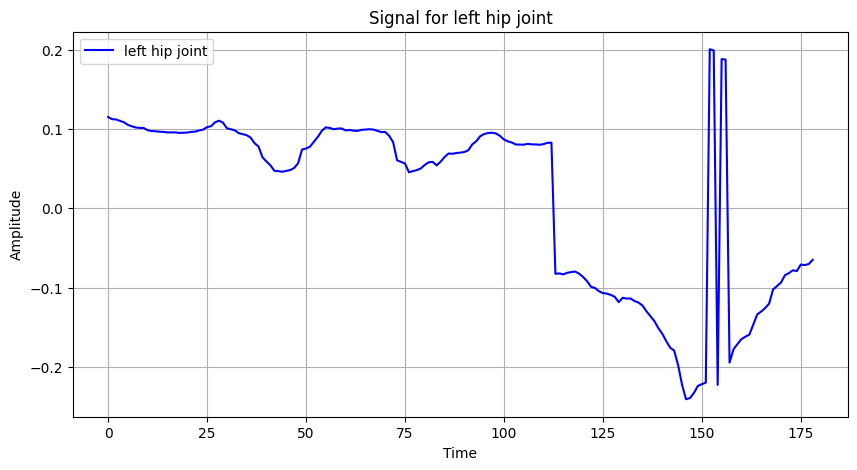

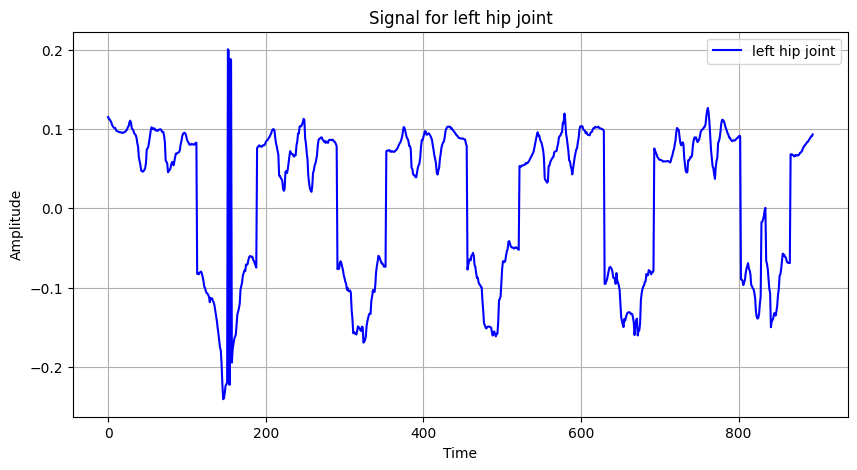

P11
P12
P13
deleted sample
P15
P16
deleted sample
P18
P19
deleted sample
P20
deleted sample
P22
P23
P24
P25
P26
P27
P28
P29
P3
P30
P31
P32
deleted sample
P34
P35
P36
P37
P38
P39
P4
P40
P41
P42
P43
deleted sample
P45
P46
P47
deleted sample
deleted sample
P5
P50
P51
deleted sample
P53
P54
P55
P56
deleted sample
P58
deleted sample
P6
P60
P61
P62
P63
P64
deleted sample
deleted sample
P67
deleted sample
P69
P7
P70
P71
P72
P73
P74
P75
P76
deleted sample
deleted sample
P9
1464000


In [7]:
samples=[]
i=0
for filepath in sorted(glob.iglob(dir_name + '**/*.csv', recursive=True)):
  #make_samples(filepath)
  x=make_samples(filepath)
  if x is None:
    print('deleted sample')
  else:
    samples_each_id_3,id=x# Three samples from each participant ID
    samples.append(samples_each_id_3[0])
    samples.append(samples_each_id_3[1])
    samples.append(samples_each_id_3[2])
    print(id)
df_samples = pd.concat(samples, axis=0, ignore_index=True)
print(df_samples.size)

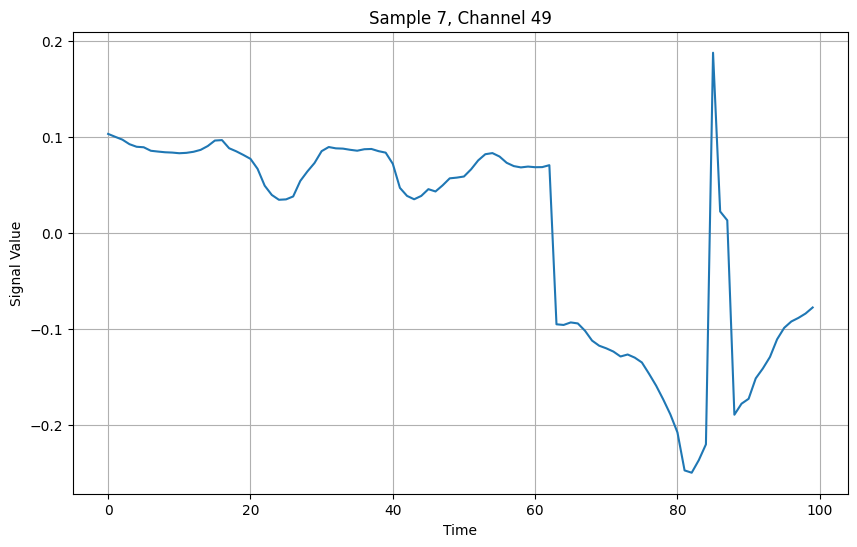

           col1      col2      col3      col4      col5      col6      col7  \
0      0.014645  0.008997  0.004613 -0.008671  0.022065  0.008621  0.005441   
1      0.014947  0.009093  0.004621 -0.008779  0.022156  0.008734  0.005437   
2      0.015223  0.009155  0.004640 -0.008738  0.022341  0.008804  0.005451   
3      0.013969  0.009316  0.004560 -0.008824  0.021896  0.008901  0.005417   
4      0.013902  0.009414  0.004529 -0.009151  0.021992  0.008986  0.005397   
...         ...       ...       ...       ...       ...       ...       ...   
18295  0.029919  0.023683  0.043579  0.058466  0.021838  0.024755  0.040697   
18296  0.047873  0.029550  0.043556  0.060964  0.032502  0.031317  0.040820   
18297  0.070150  0.033236  0.043008  0.063449  0.047367  0.035670  0.040704   
18298  0.080729  0.036118  0.042606  0.065203  0.068423  0.037569  0.039946   
18299  0.082807  0.040755  0.042434  0.065491  0.076009  0.041703  0.039553   

           col8      col9     col10  ...     col71 

In [8]:
#Normalize the final data
numpy_array = df_samples.to_numpy()
reshaped_array = numpy_array.reshape(183, 100, 80)
normalized_data=normalize_signal(reshaped_array) #this is the final data
data_to_plot = normalized_data[6, :, 48]
# Create a time array (assuming time starts from 0 and is evenly spaced)
time = np.arange(100)  # Assuming 100 time points

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(time, data_to_plot)
plt.title(f"Sample {7}, Channel {49}")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.grid(True)

# Show the plot
plt.show()

reshaped_array_final = normalized_data.reshape(18300, 80)
column_names = ["col" + str(i) for i in range(1, 81)]
df = pd.DataFrame(reshaped_array_final, columns=column_names)
print(df)
# Specify the file path and name where you want to save the CSV file
file_path = '/content/drive/My Drive/new_kimore/Preprocessed_data/Exercise2_data.csv'  # Change this to your desired path and file name

# Save the NumPy array as a CSV file
df.to_csv(file_path, index=False)